### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading VOC dataset

This ipynotebook is modified from [qubvel\`s repo](https://github.com/qubvel/segmentation_models/tree/master/examples) to adjust to VOC07 or VOC12 dataset. As an exercise for the further implement of a custom dataset

In [12]:
import os
from os.path import join as pjoin
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\zhaoc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zhaoc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zhaoc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zhaoc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Download the VOCdevkit07 and VOCdevkit12, and unpack the zip file directly in the /data folder

In [22]:
ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2012')
ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2007')

#### Dataloader and utility functions 

In [15]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

#### Overview of the VOC dataset
##### 21 classes and their colors

In [106]:
PASCAL_COLORS=[
[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],[0, 0, 128],[128, 0, 128],
[0, 128, 128],[128, 128, 128],[64, 0, 0],[192, 0, 0],[64, 128, 0],[192, 128, 0],
[64, 0, 128],[192, 0, 128],[64, 128, 128],
[192, 128, 128],[0, 64, 0],[128, 64, 0],[0, 192, 0],[128, 192, 0],[0, 64, 128],
]
PASCAL_CLASSES = ['background','aeroplane','bicycle','bird','boat',
'bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike',
'person','pottedplant','sheep','sofa','train','tvmonitor']

In [107]:
l = zip(PASCAL_CLASSES,PASCAL_COLORS)
for c,color in l:
    print(c,':',color)

background : [0, 0, 0]
aeroplane : [128, 0, 0]
bicycle : [0, 128, 0]
bird : [128, 128, 0]
boat : [0, 0, 128]
bottle : [128, 0, 128]
bus : [0, 128, 128]
car : [128, 128, 128]
cat : [64, 0, 0]
chair : [192, 0, 0]
cow : [64, 128, 0]
diningtable : [192, 128, 0]
dog : [64, 0, 128]
horse : [192, 0, 128]
motorbike : [64, 128, 128]
person : [192, 128, 128]
pottedplant : [0, 64, 0]
sheep : [128, 64, 0]
sofa : [0, 192, 0]
train : [128, 192, 0]
tvmonitor : [0, 64, 128]


##### the number of images with trainable mask
it is clearly shown that the dataset is unbalanced, the class 'person' has most masks

([<matplotlib.axis.XTick at 0x1c23ffb1408>,
 <a list of 20 Text xticklabel objects>)

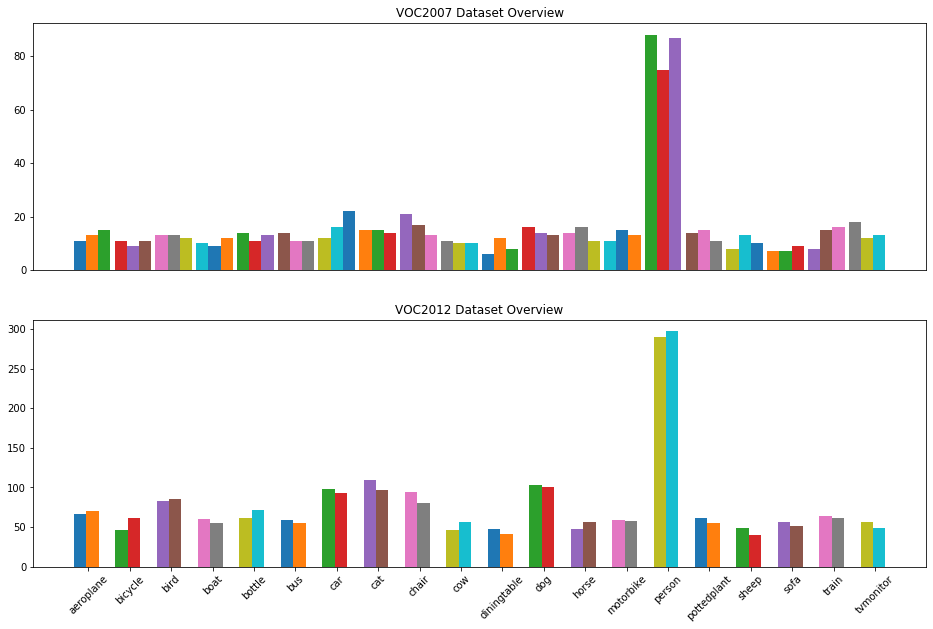

In [131]:
ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2012')
ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2007')
def get_splits(ROOT_DIR): 
    if '2007' in ROOT_DIR:
        splits = ['train','val','test']
    elif '2012' in ROOT_DIR:
        splits = ['train','val']
    
    return splits

def get_class_info(class_name, year):
    '''
    get the trainable images number of a certain class of a certain year
    Args:
        class_name: str, one from the PASCAL_CLASSES
        year: str, 2007 or 2012
    '''
    
    ROOT_DIR = pjoin('.','data','VOCdevkit','VOC'+year)
    classtxt_dir = pjoin(ROOT_DIR,'ImageSets','Main')
    txt_dir = pjoin(ROOT_DIR,'ImageSets','Segmentation')
    info_dict={}
    for split in get_splits(ROOT_DIR):
        class_path = pjoin(classtxt_dir,class_name+'_'+split+'.txt')
        file_list = tuple(open(class_path, "r"))
        
        class_ids = [id_.split()[0] for id_ in file_list if id_.split()[1] == '1']
        
        mask_path = pjoin(txt_dir,split+'.txt')
        file_list = tuple(open(mask_path, "r"))
        ids = [file_id.rstrip() for file_id in file_list]
        
        inter_ids = [id_ for id_ in class_ids if id_ in ids]
        
        info_dict[split]=(len(inter_ids))
        
    return info_dict

fig,axn = plt.subplots(2,1,figsize=(16,10))      
for i, c in enumerate(PASCAL_CLASSES):
    if c !='background':
        info = get_class_info(c,'2007')
        axn[0].bar(i-1.2,info['train'],width=0.3)
        axn[0].bar(i-0.9,info['val'],width=0.3)
        axn[0].bar(i-0.6,info['test'],width=0.3)
axn[0].set_title('VOC2007 Dataset Overview')
axn[0].set_xticks([])
for i, c in enumerate(PASCAL_CLASSES):
    if c !='background':
        info = get_class_info(c,'2012')
        axn[1].bar(i-1.2,info['train'],width=0.3)
        axn[1].bar(i-0.9,info['val'],width=0.3)
axn[1].set_title('VOC2012 Dataset Overview')
plt.xticks(ticks=range(20),labels=PASCAL_CLASSES[1:],rotation=45)

#### Dataset Class for VOC dataset
, merged some ideas from [meetshah1995](https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/pascal_voc_loader.py)

In [19]:
class VOCDataset:
    '''
    Dataset of VOC
    Args:
        root_dir: str, root dir of the voc dev kit
        which_split: str, one from 'train', 'val', 'test'
        classes: list, list of classes to be trained
    '''
    # PASCAL VOC 21 Classes name and their colors
    PASCAL_COLORS=[
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
   
    PASCAL_CLASSES = ['background',
                      'aeroplane',
                      'bicycle',
                      'bird',
                      'boat',
                      'bottle',
                      'bus',
                      'car',
                      'cat',
                      'chair',
                      'cow',
                      'diningtable',
                      'dog',
                      'horse',
                      'motorbike',
                      'person',
                      'pottedplant',
                      'sheep',
                      'sofa',
                      'train',
                      'tvmonitor'
                     ]
    
    def __init__(
    self,
    root_dir,
    which_split,
    classes=None,
    augmentation=None,
    preprocessing=None
    ):
        for c in classes:
            assert c in self.PASCAL_CLASSES, '\'%s\' is not a class in PASCAL07'%c
        #convert chosen class name to class index
        self.class_values = [self.PASCAL_CLASSES.index(cls.lower()) for cls in classes]
        #root dir
        self.root_dir = root_dir
        #.jpg and .png file dir
        imgs_dir = pjoin(root_dir,'JPEGImages')
        masks_dir = pjoin(root_dir,'SegmentationClass')
        #image name list .txt file dir 
        masktxt_dir = pjoin(root_dir,'ImageSets','Segmentation')
        classtxt_dir = pjoin(root_dir,'ImageSets','Main')
        #create the file id list of all images with masks
        file_path = pjoin(masktxt_dir, which_split + ".txt")
        file_list = tuple(open(file_path, "r"))
        mask_ids = [id_.rstrip() for id_ in file_list]
        
        #if only one class is chosen, create the file id list of this explict chosen class
        if len(classes)==1:
            c = classes[0]
            file_path= pjoin(classtxt_dir,c+'_'+which_split+'.txt')
            file_list = tuple(open(file_path, "r"))
            #slice op here: class string ends with '1' if exists in the image, otherwise '-1'
            class_ids = [id_.split()[0] for id_ in file_list if id_.split()[1] == '1']
            self.ids = [id_ for id_ in class_ids if id_ in mask_ids]
        else:
            self.ids = mask_ids
            
        #create filepath
        self.img_filepaths = [pjoin(imgs_dir, img_id)+'.jpg' for img_id in self.ids]
        self.mask_filepaths = [pjoin(masks_dir,img_id)+'.png' for img_id in self.ids]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self,index):
        img_name = self.img_filepaths[index]
        mask_name = self.mask_filepaths[index]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        #change class color value to coresponind class id value in the mask
        mask = self._encode_segmap(mask)
        #extracts chosen classes as one-hot code
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
    
    def _encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes
        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.
        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.PASCAL_COLORS):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        
        return label_mask
        
        
    

##### visualize one image in the dataset as example

In [49]:
path2= pjoin(ROOT_DIR,'SegmentationClass','000129.png')
original_mask = cv2.imread(path2)
original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)

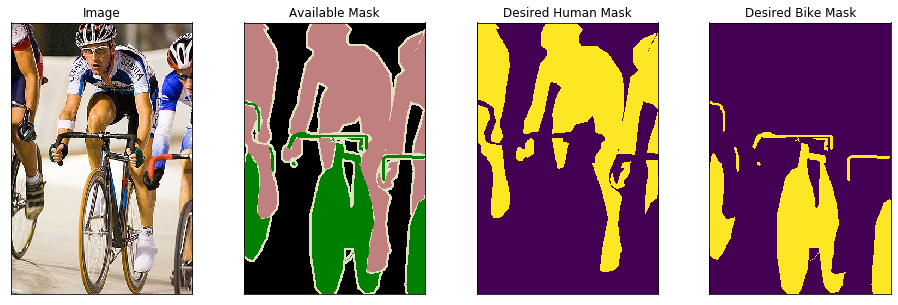

209


In [54]:
#show some data in the voc dataset
train_data = VOCDataset(ROOT_DIR,'train',classes=['person','bicycle'])
img, mask = train_data[4]
visualize(image=img,
          available_mask=original_mask,
          desired_human_mask=mask[...,0],
         desired_bike_mask=mask[...,1])
print('train set image number:',len(train_data))

#### Dataloader class
used for stack the items in Dataset to create batch

In [51]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [12]:
import albumentations as A

In [13]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32
    the voc dataset images have various resolution
    """
    test_transform = [
        A.Resize(320,320,interpolation=cv2.INTER_LINEAR)
        #A.PadIfNeeded(384, 480)
        #A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #A.RandomCrop(height=320, width=320, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

#### show some data after augmentation in the voc dataset

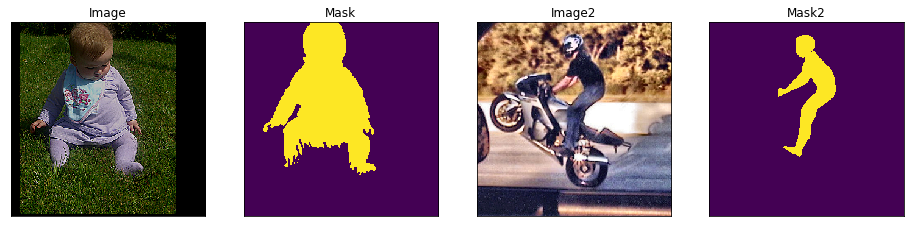

In [18]:
dataset = VOCDataset(ROOT_DIR,
                     'train',
                     classes=['person'],
                     augmentation=get_training_augmentation()
                    )
image, mask = dataset[12]
image2,mask2 = dataset[0]
visualize(
    image=image, 
    mask = mask[..., 0].squeeze(),
    image2 = image2,
    mask2 = mask2[...,0].squeeze()
)

# Segmentation model training

In [19]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [20]:
BACKBONE = 'mobilenetv2'
BATCH_SIZE = 4
CLASSES = ['person']
LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [21]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#### create a new blank model

In [ ]:
model = sm.Unet(BACKBONE,
                classes=n_classes,
                activation=activation,
               encoder_weights='imagenet',
               encoder_freeze=True)

#### create a model with pre-trained weights for retraining

In [22]:
model = sm.Unet(BACKBONE,
                classes=n_classes,
                activation=activation,
                weights='best_model_mobilnetv2.h5',
               encoder_weights='imagenet',
               encoder_freeze=True)

C:\Users\zhaoc\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [23]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

import json
model_json = model.to_json()
with open('efficientnet.json','w') as f:
    json.dump(model_json,f)

In [18]:
#ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2012')

In [24]:
# Dataset for train images
train_dataset = VOCDataset(ROOT_DIR,
                        'train',
                        classes=CLASSES,
                        augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

# Dataset for validation images
valid_dataset = VOCDataset(ROOT_DIR,
                        'val',
                        classes=CLASSES,
                        augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocess_input))

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
print('train img size:',train_dataloader[0][0].shape)
print('train mask size:',train_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
#weights_filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_mobilnetv2.h5',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

train img size: (4, 320, 320, 3)
train mask size: (4, 320, 320, 1)


In [25]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=10,#EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
72/72 [==============================] - 529s 7s/step - loss: 0.4936 - iou_score: 0.5187 - f1-score: 0.6664 - val_loss: 0.2533 - val_iou_score: 0.4705 - val_f1-score: 0.5672
Epoch 2/10
72/72 [==============================] - 512s 7s/step - loss: 0.4633 - iou_score: 0.5444 - f1-score: 0.6854 - val_loss: 0.5227 - val_iou_score: 0.5363 - val_f1-score: 0.6376
Epoch 3/10
72/72 [==============================] - 496s 7s/step - loss: 0.4510 - iou_score: 0.5467 - f1-score: 0.6913 - val_loss: 0.2054 - val_iou_score: 0.5386 - val_f1-score: 0.6410
Epoch 4/10
72/72 [==============================] - 497s 7s/step - loss: 0.4291 - iou_score: 0.5644 - f1-score: 0.7065 - val_loss: 0.2247 - val_iou_score: 0.5017 - val_f1-score: 0.5996
Epoch 5/10
72/72 [==============================] - 499s 7s/step - loss: 0.4277 - iou_score: 0.5647 - f1-score: 0.7076 - val_loss: 0.0879 - val_iou_score: 0.5368 - v

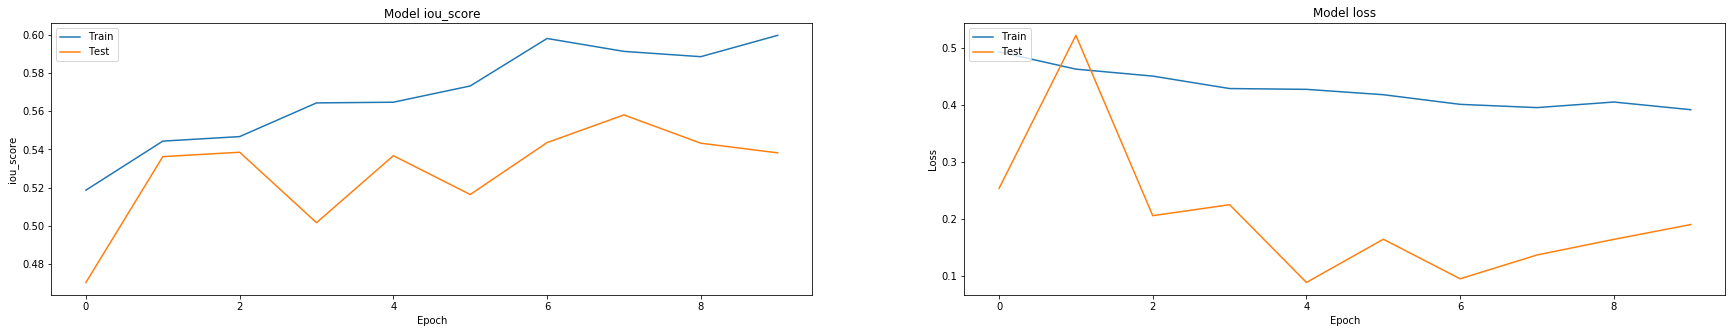

In [26]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [27]:
ROOT_DIR = pjoin('.','data','VOCdevkit','VOC2007')

In [28]:

test_dataset = VOCDataset(ROOT_DIR,
                          'test',
                          classes=CLASSES,
                          augmentation=get_validation_augmentation(),
                          preprocessing=get_preprocessing(preprocess_input)
                         )

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [29]:
# load best weights
model.load_weights('best_model_mobilnetv2.h5') 

In [30]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.28238
mean iou_score: 0.53807
mean f1-score: 0.64413


# Visualization of results on test dataset

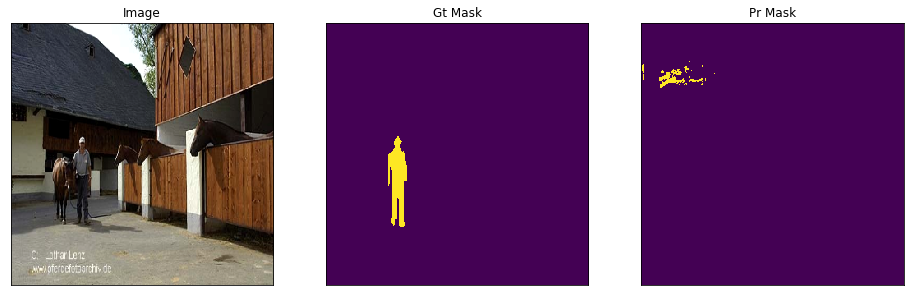

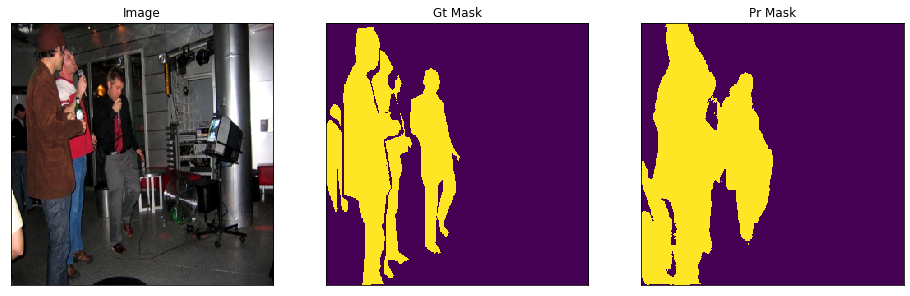

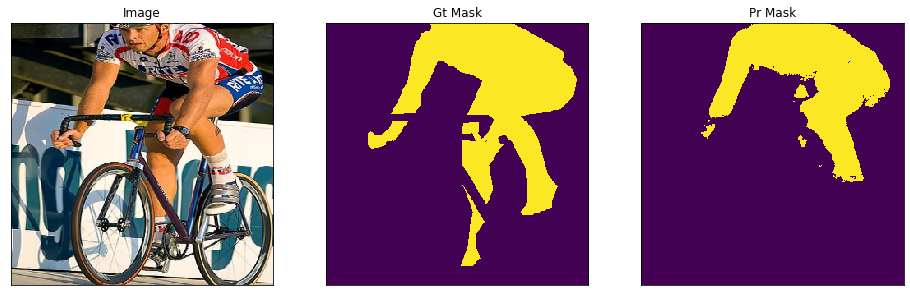

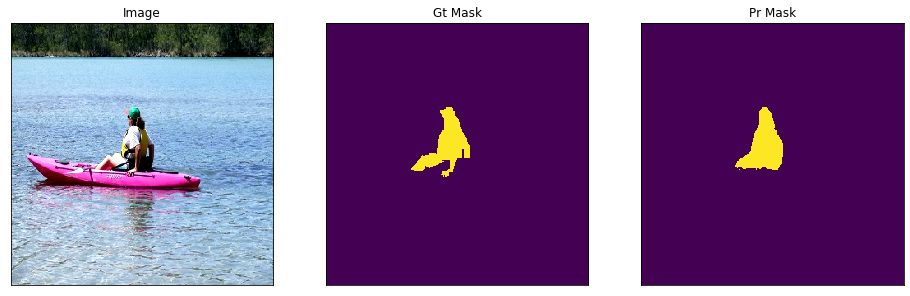

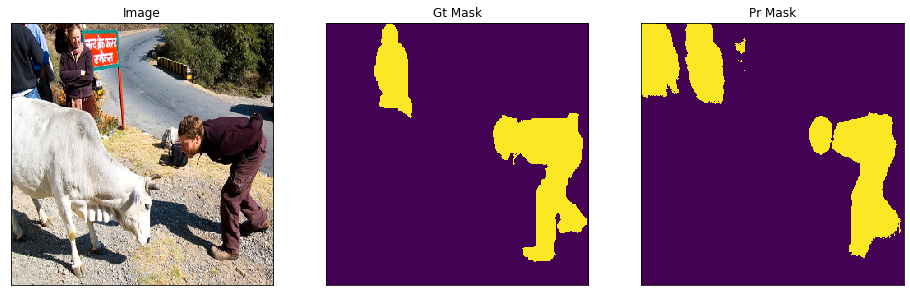

In [34]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

#### test the model with one own image

In [ ]:
image = cv2.imread('./data/MyImages/party.jpg')

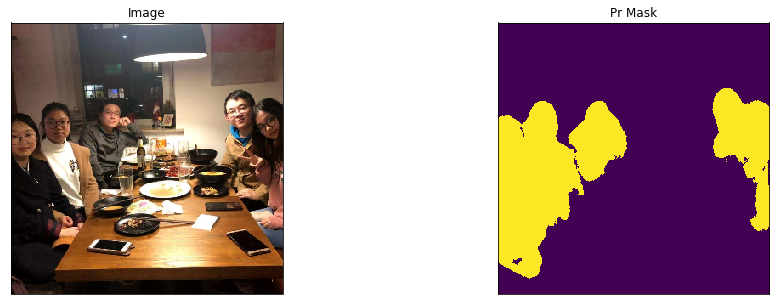

In [37]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
aug = get_validation_augmentation()
sample = aug(image=image)
image = sample['image']
pre = get_preprocessing(preprocess_input)
sample = pre(image=image)
image = sample['image']

image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image).round()
visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., 0].squeeze(),
    )